In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-jobs-on-monstercom/monster_com-job_sample.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import warnings
warnings.filterwarnings("ignore")

# EDA

### Initial Data Checks

In [8]:
df = pd.read_csv("/kaggle/input/us-jobs-on-monstercom/monster_com-job_sample.csv")
df.shape

(22000, 14)

In [10]:
df.sample(10)

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
6280,United States of America,US,NaN,No,jobs.monster.com,91L Construction Vehicle Repairer Job Descript...,L Construction Vehicle Repairer Job in Salinas,Full Time Employee,"Salinas, PR 00079",NaN,http://jobview.monster.com/91l-construction-ve...,NaN,Entry Level,15ec6f706c38e19a015c1f982fa47758
9745,United States of America,US,NaN,No,jobs.monster.com,"About Us: EMCOR Facilities Services (EFS), an ...",Commercial Maintenance Technician - Entry Leve...,Full Time Employee,Location:,Real Estate/Property Management,http://jobview.monster.com/Commercial-Maintena...,NaN,Installation/Maintenance/Repair,dc101ddb3ac1bf2668e821bc62a4620a
18485,United States of America,US,NaN,No,jobs.monster.com,Old Vineyard Behavioral Health Services is the...,Licensed Therapist,"Full Time, Employee","Winston-Salem, NC 27104",Healthcare Services,http://jobview.monster.com/Licensed-Therapist-...,NaN,Medical/Health,fb924da8a535a7d59efdf12814ed5401
2498,United States of America,US,NaN,No,jobs.monster.com,Overview The ideal candidate should be enthusi...,District Manager Job in Baton Rouge,Full Time Employee,"Baton Rouge, LA",NaN,http://jobview.monster.com/district-manager-jo...,NaN,NaN,77332e1eabe515cee0a34dbfb232635d
12948,United States of America,US,NaN,No,jobs.monster.com,Job Responsibilities: Mercury Systems is seeki...,Project Analyst Job in Chelmsford,Full Time,"Chelmsford, MA 01824",NaN,http://jobview.monster.com/Project-Analyst-Job...,NaN,NaN,32f1c10553da3b1b9c3e4d84f53e366c
5331,United States of America,US,NaN,No,jobs.monster.com,General Responsibilities:Overview:About the Jo...,Compliance Attorney Job in Estero,Full Time / Employee,"Estero, FL",NaN,http://jobview.monster.com/Compliance-Attorney...,NaN,Legal,98f2c5b5801e5f6855c46b3e60f3a5e4
13921,United States of America,US,NaN,No,jobs.monster.com,Quality Manager - Automotive - GA/JBU/19065TOP...,Quality Manager - Automotive - GA/JBU/ Job in ...,Full Time,"Atlanta, GA",NaN,http://jobview.monster.com/Quality-Manager-Aut...,"65,000.00 - 75,000.00 $ /year",NaN,a34ff0b9da219586436912d6a9557b53
8068,United States of America,US,NaN,No,jobs.monster.com,RN Case Manager- DADS (Department of Aging and...,RN Case Manager Job in Lubbock,"Full Time, Employee","Lubbock, TX",Healthcare Services,http://jobview.monster.com/RN-Case-Manager-Job...,NaN,Medical/Health,718b231bc71ae1eaec1054823ddfa630
12111,United States of America,US,NaN,No,jobs.monster.com,"Our client, north of the city is looking for a...",Employee Engagement Specialist Job in Boston,Full Time Employee,BostonMA,Food and Beverage Production,http://jobview.monster.com/Employee-Engagement...,"40,000.00 - 50,000.00 $ /year",Human Resources,9d5f3389f9ab91ccf2d16fc6a9c7b460
2346,United States of America,US,NaN,No,jobs.monster.com,Ajilon is hiring for a full-time Recruiter in ...,Recruiter Job in Boston,Full Time Temporary/Contract/Project,"Boston, MA 02210",NaN,http://jobview.monster.com/recruiter-job-in-bo...,"50,000.00 - 60,000.00 $ /year",Human Resources,251838f570b108a1a10889df00023527


In [12]:
df.columns
df.dtypes

country            object
country_code       object
date_added         object
has_expired        object
job_board          object
job_description    object
job_title          object
job_type           object
location           object
organization       object
page_url           object
salary             object
sector             object
uniq_id            object
dtype: object

In [13]:
df.describe(include='all')

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
count,22000,22000,122,22000,22000,22000,22000,20372,22000,15133,22000,3446,16806,22000
unique,1,1,78,1,1,18744,18759,39,8423,738,22000,1737,163,22000
top,United States of America,US,9/22/2016,No,jobs.monster.com,12N Horizontal Construction Engineers Job Desc...,Monster,Full Time,"Dallas, TX",Healthcare Services,http://jobview.monster.com/it-support-technici...,"40,000.00 - 100,000.00 $ /year",Experienced (Non-Manager),11d599f229a80023d2f40e7c52cd941e
freq,22000,22000,6,22000,22000,104,318,6757,646,1919,1,50,4594,1


### Missing Value Analysis

date_added         21878
salary             18554
organization        6867
sector              5194
job_type            1628
country                0
country_code           0
has_expired            0
job_board              0
job_description        0
job_title              0
location               0
page_url               0
uniq_id                0
dtype: int64

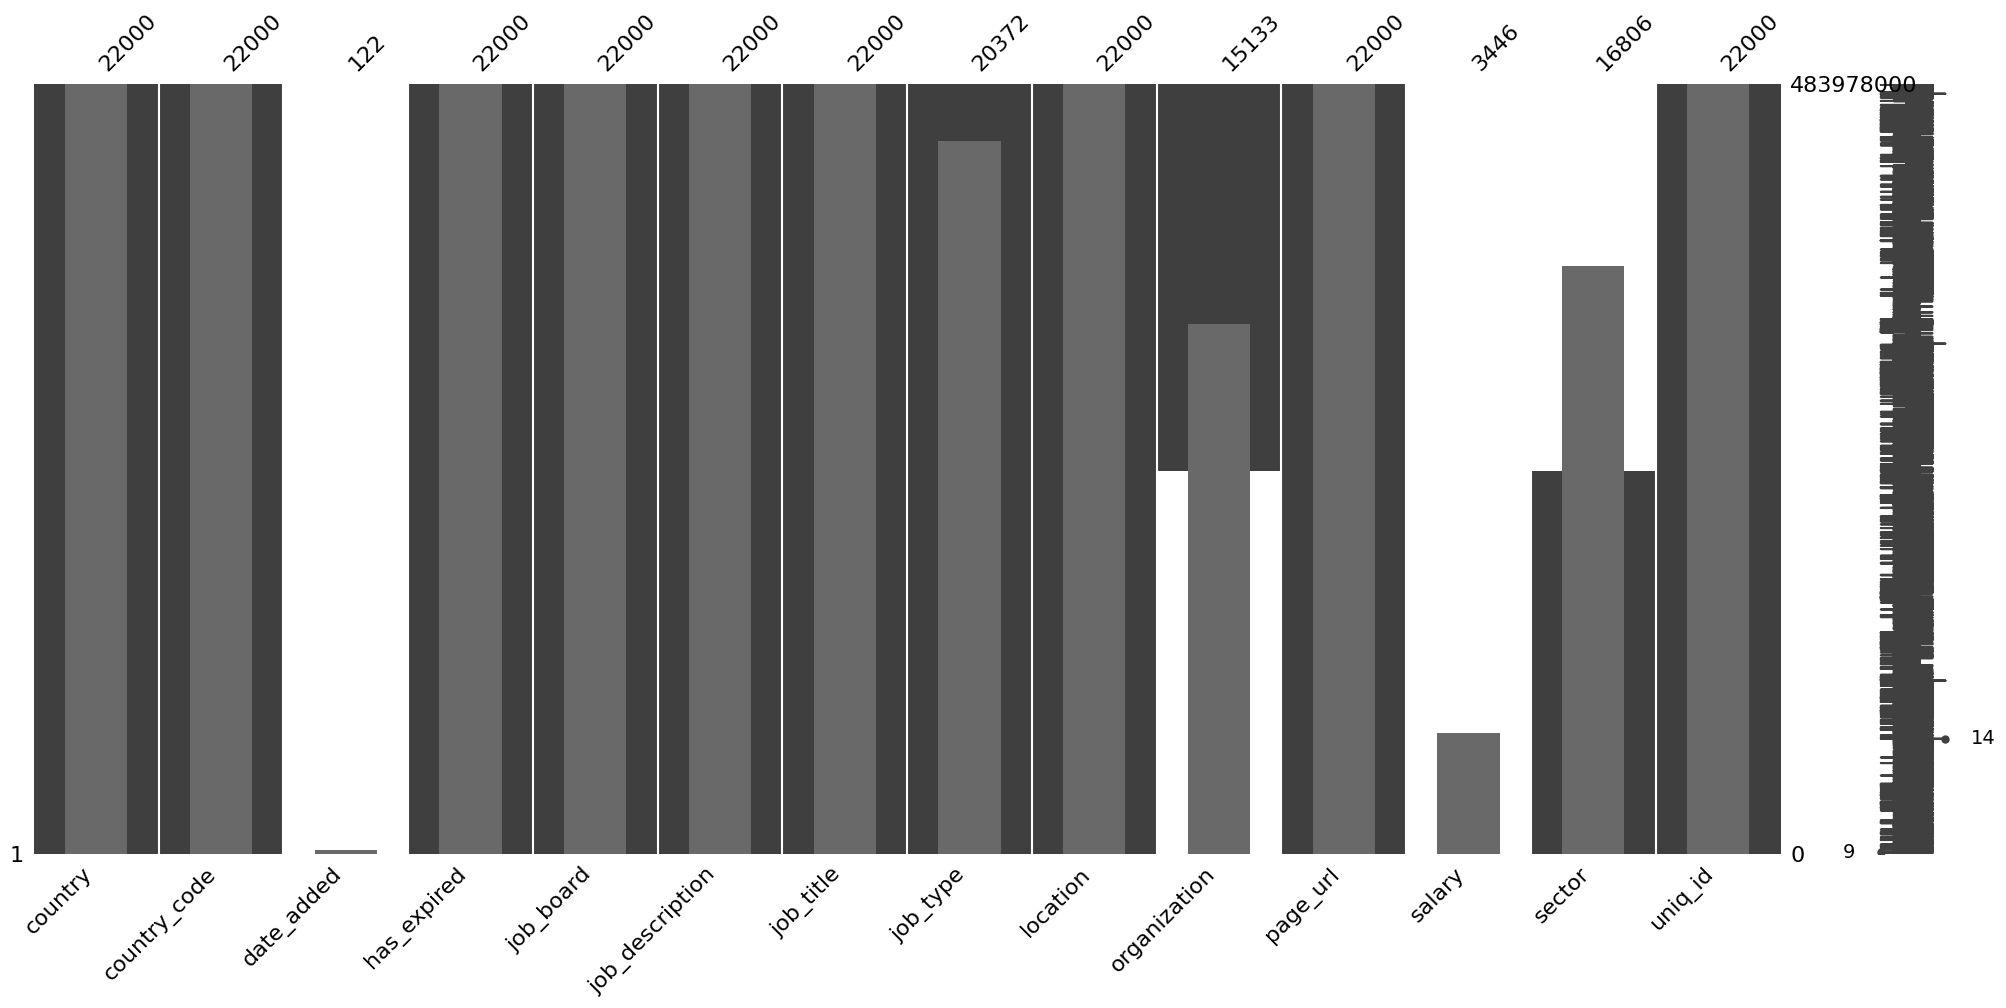

In [14]:
# Visualize missing data
msno.matrix(df)
msno.bar(df)
df.isnull().sum().sort_values(ascending=False)

### Cleaning Specific Columns

#### Clean location

In [15]:
# Split location into city and state (if present)
df[['city', 'state']] = df['location'].str.extract(r'([^,]+),\s*(\w{2})')

#### Normalize job_type, sector, organization

In [16]:
df['job_type'] = df['job_type'].str.lower().str.strip()
df['sector'] = df['sector'].str.lower().str.strip()
df['organization'] = df['organization'].str.title().str.strip()


#### Drop or flag high-missing columns (date_added, salary)

In [17]:
df.drop(columns=['date_added', 'salary'], inplace=True)


### Univariate Visualizations

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Text(0.5, 1.0, 'Job Type Distribution')

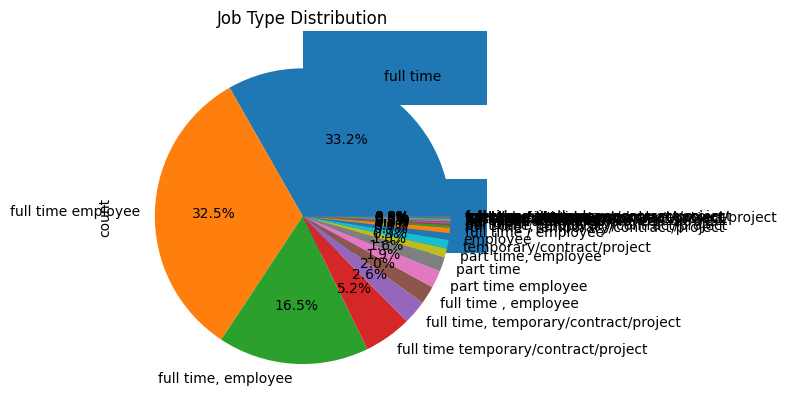

In [18]:
# Top 10 job titles
df['job_title'].value_counts().head(10).plot(kind='barh')
plt.title('Top Job Titles')

# Top 10 sectors
df['sector'].value_counts().head(10).plot(kind='barh')
plt.title('Top Sectors')

# Job Type Distribution
df['job_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Job Type Distribution')


### Saving the cleaned dataset

In [20]:
df.to_csv("cleaned_monster_jobs.csv", index=False)
print("Cleaned data has been saved to 'cleaned_monster_jobs.csv'.")


Cleaned data has been saved to 'cleaned_monster_jobs.csv'.


In [24]:
df_new = pd.read_csv("cleaned_monster_jobs.csv")
df_new.shape

(22000, 14)

In [25]:
df_new.isnull().sum()

country               0
country_code          0
has_expired           0
job_board             0
job_description       0
job_title             0
job_type           1628
location              0
organization       6867
page_url              0
sector             5194
uniq_id               0
city               1936
state              1936
dtype: int64